In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.base import BaseForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error


In [78]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime

# no keys required for crypto data
client = CryptoHistoricalDataClient()

request_params = CryptoBarsRequest(
                        symbol_or_symbols=["BTC/USD", "ETH/USD"],
                        timeframe=TimeFrame.Day,
                        start=datetime(2020, 7, 1),
                        end=datetime(2022, 9, 1)
                 )

bars = client.get_crypto_bars(request_params)

# convert to dataframe
bars.df

open      high       low     close  \
symbol  timestamp                                                           
BTC/USD 2021-01-01 06:00:00+00:00  29255.71  29682.29  28707.56  29676.79   
        2021-01-02 06:00:00+00:00  29678.34  34200.00  29555.99  33769.52   
        2021-01-03 06:00:00+00:00  33769.52  34812.93  32300.61  32908.02   
        2021-01-04 06:00:00+00:00  32907.36  33496.03  27900.00  30441.57   
        2021-01-05 06:00:00+00:00  30461.84  35851.42  29927.55  35063.00   
...                                     ...       ...       ...       ...   
ETH/USD 2022-08-27 05:00:00+00:00   1493.48   1511.79   1448.00   1487.49   
        2022-08-28 05:00:00+00:00   1487.26   1504.06   1422.62   1449.34   
        2022-08-29 05:00:00+00:00   1449.72   1585.87   1439.38   1582.42   
        2022-08-30 05:00:00+00:00   1581.71   1619.18   1473.86   1606.47   
        2022-08-31 05:00:00+00:00   1606.00   1615.20   1528.38   1551.61   

                                         volume  trade_count          vwap  
symbol  timestamp                                                           
BTC/USD 2021-01-01 06:00:00+00:00    848.874030      29639.0  29316.444625  
        2021-01-02 06:00:00+00:00   2144.592516      60152.0  31941.412694  
        2021-01-03 06:00:00+00:00   1838.695433      58725.0  33505.269474  
        2021-01-04 06:00:00+00:00   2711.189503      69226.0  31267.965121  
        2021-01-05 06:00:00+00:00   1756.751333      61880.0  33151.367357  
...                                         ...          ...           ...  
ETH/USD 2022-08-27 05:00:00+00:00  42747.302610      35194.0   1485.111022  
        2022-08-28 05:00:00+00:00  33260.757210      30611.0   1466.512520  
        2022-08-29 05:00:00+00:00  32337.384620      32339.0   1519.419735  
        2022-08-30 05:00:00+00:00  42796.609810      47908.0   1550.528583  
        2022-08-31 05:00:00+00:00  27012.961130      27417.0   1569.038958  

[1216 rows x 7 columns]

<AxesSubplot:xlabel='timestamp'>

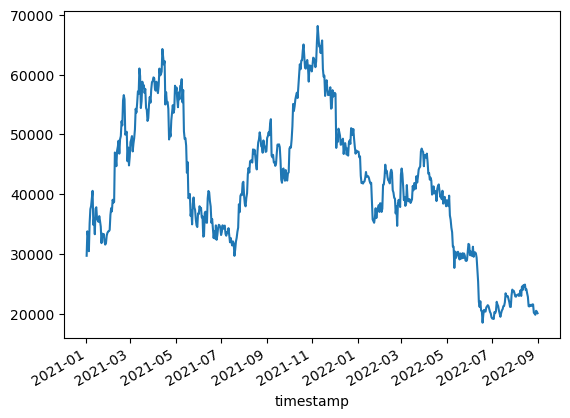

In [79]:
BTC_data = bars.df.loc['BTC/USD']
BTC_data['close'].plot()

<AxesSubplot:>

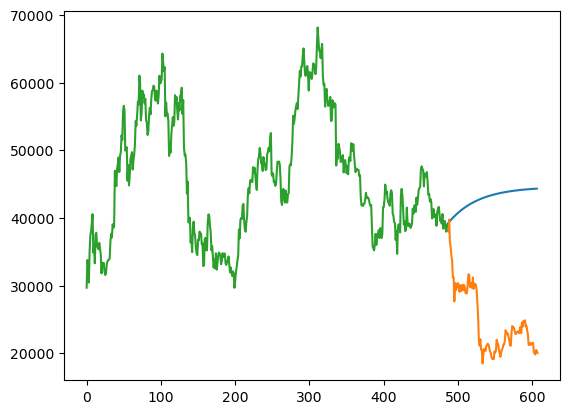

In [80]:
from sktime.forecasting.arima import ARIMA
y = BTC_data['close'].reset_index(drop=True)
y_train, y_test = temporal_train_test_split(y, test_size=0.2)
fh = ForecastingHorizon(np.arange(len(y_test)))
forecaster = ARIMA()
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict()
y_pred.plot()
y_test.plot()
y_train.plot()
